In [1]:
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym import wrappers
from time import sleep

Using TensorFlow backend.


In [22]:
class DQNAgent:

    def __init__(self, state_size, action_size):
        
        self.render = False
        self.load_model = True
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.1
        self.batch_size = 128
        self.train_start = 1000
        
        self.memory = deque(maxlen=2000)
        
        self.model = self.build_model()
        if self.load_model:
            self.model.load_weights("./pacman.h5")
    
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)
        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])
        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        for i in range(self.batch_size):           
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))
                
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=5, verbose=0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_24 (Dense)             (None, 9)                 297       
Total params: 20,937
Trainable params: 20,937
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 280.0   memory length: 699   epsilon: 0.9324838046961919
episode: 1   score: 340.0   memory length: 1407   epsilon: 0.868743785535615
episode: 2   score: 230.0   memory length: 2000   epsilon: 0.8098465078911652


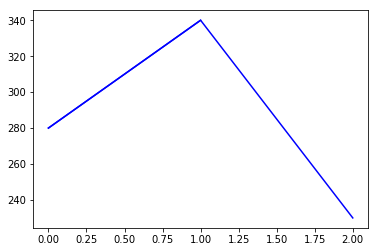

In [34]:
env = gym.make('MsPacman-ram-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
scores, episodes = [], []
EPISODES = 2500

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    lives = 3
    while not done: 
        dead = False         
        while not dead:
            if agent.render:
                env.render()
            
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])           
            agent.append_sample(state, action, reward, next_state, done)           
            agent.train_model()
            state = next_state            
            score += reward
            dead = info['ale.lives']<lives
            lives = info['ale.lives']
            
            reward = reward if not dead else -100
        if done:
            env.close()
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')           
            print("episode:", e, "  score:", score, "  memory length:",
                    len(agent.memory), "  epsilon:", agent.epsilon)
    if e % 20 == 0:
            agent.model.save_weights("./pacman.h5")

In [31]:
def play():                               
    obs = env.reset()
    state = obs
    done = False
    state = np.reshape(state, [1, state_size])
    while not done:
        env.render()   
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size]) 
        state = next_state
        sleep(0.05)
    env.close()
    print('done!')
    

In [43]:
play()

done!
